In [ ]:
%pip install pandas numpy matplotlib seaborn rapidfuzz

In [561]:
import os
from preprocessing import read_file, extract_filtered, SongAttributes
from pprint import pp

from typing import cast, Literal
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
pd.set_option("display.expand_frame_repr", False)

from fuzzy_searchers import *
from generic_plots import Plots

In [560]:
# extract the "Spotify Extended Streaming History.zip" in a folder named data, sibling to this script

data_folder = os.path.join(os.path.abspath(''), "data")
print(data_folder)
# only reading Audio History files
files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.startswith("Streaming_History_Audio")]
songs = [song for file in files for song in read_file(file)]

/home/divij/coding/projects/spotify-data-analysis/data


In [428]:
filters: list[SongAttributes] = ["ts", "ms_played", "master_metadata_track_name", "master_metadata_album_artist_name", "master_metadata_album_album_name"]
filtered = [extract_filtered(song, filters) for song in songs]

In [429]:
df = pd.DataFrame(filtered)

In [458]:
df

ts  ms_played                 master_metadata_track_name master_metadata_album_artist_name master_metadata_album_album_name
0      2020-11-27T07:19:29Z      21480                            Naach Meri Rani                     Guru Randhawa                  Naach Meri Rani
1      2020-11-27T07:19:30Z       1040                BurjKhalifa (From "Laxmii")                            Shashi      BurjKhalifa (From "Laxmii")
2      2020-11-27T07:19:31Z        360                    Sawan Mein Lag Gayi Aag                        Mika Singh                 Ginny Weds Sunny
3      2020-11-27T07:19:32Z        450                BurjKhalifa (From "Laxmii")                            Shashi      BurjKhalifa (From "Laxmii")
4      2020-11-27T07:19:32Z        250                    Sawan Mein Lag Gayi Aag                        Mika Singh                 Ginny Weds Sunny
...                     ...        ...                                        ...                               ...                              ...
53347  2025-08-21T13:12:12Z      28998  Leave Me Alone - Michael Jackson's Vision                   Michael Jackson                   Leave Me Alone
53348  2025-08-21T13:12:28Z      15516  Leave Me Alone - Michael Jackson's Vision                   Michael Jackson                   Leave Me Alone
53349  2025-08-22T10:48:16Z       3402                                     Misery                       Soul Asylum                           Misery
53350  2025-08-22T10:52:45Z       1301                                    Save Me                             Gotye                          Save Me
53351  2025-08-22T10:54:09Z      13947                                  N Dey Say                             Nelly                        N Dey Say

[53352 rows x 5 columns]

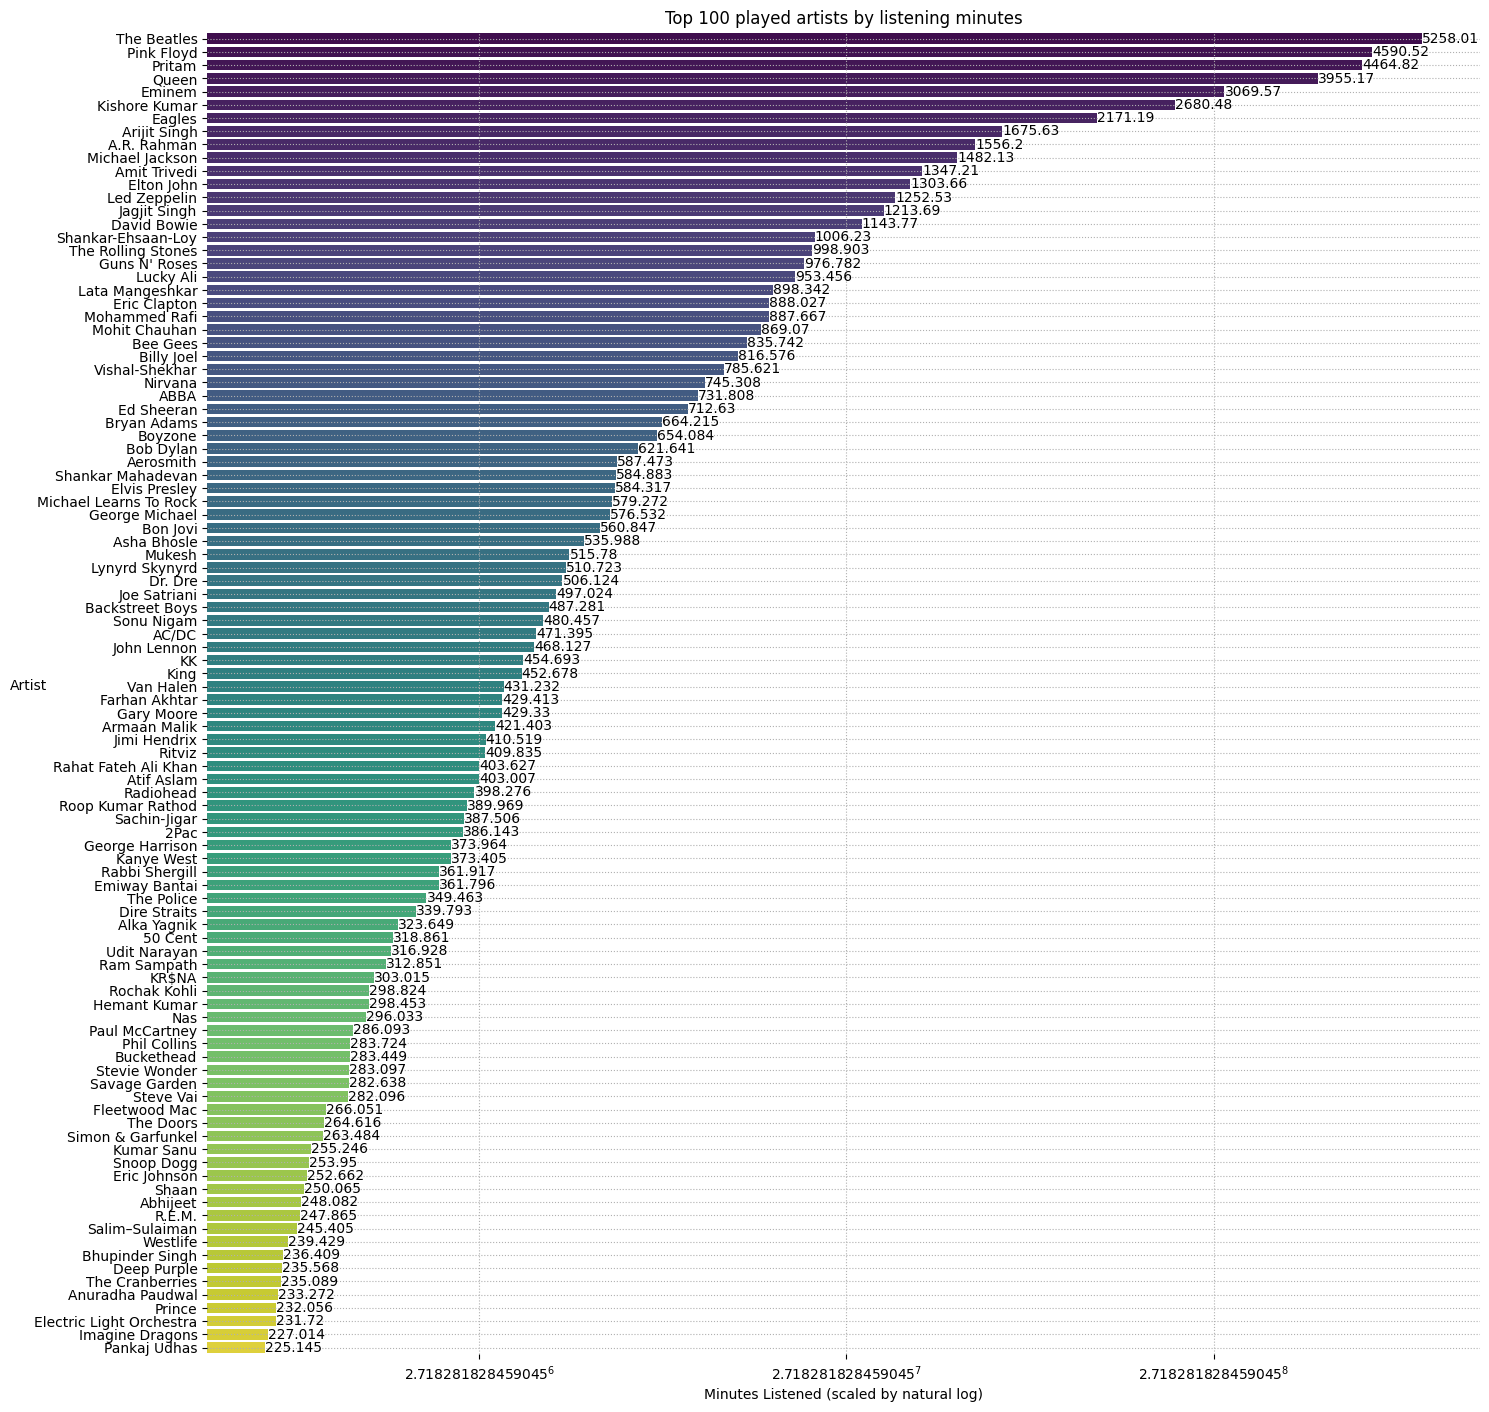

In [433]:
# Top artists by playtime
copy = df.copy(True)
grouped_by_artist_name = copy.groupby(copy["master_metadata_album_artist_name"])
time_listend = grouped_by_artist_name["ms_played"].sum()
time_listend = time_listend[time_listend != 0]
time_listend.sort_values(ascending=False, inplace=True)
time_listend_mins = time_listend.div(6e4)
time_listend_mins = cast(pd.Series, Filters.rows_gt(1, time_listend_mins))

Plots.plot_1(time_listend_mins, 100, "Top 100 played artists by listening minutes", "Minutes Listened (scaled by natural log)", "Artist")

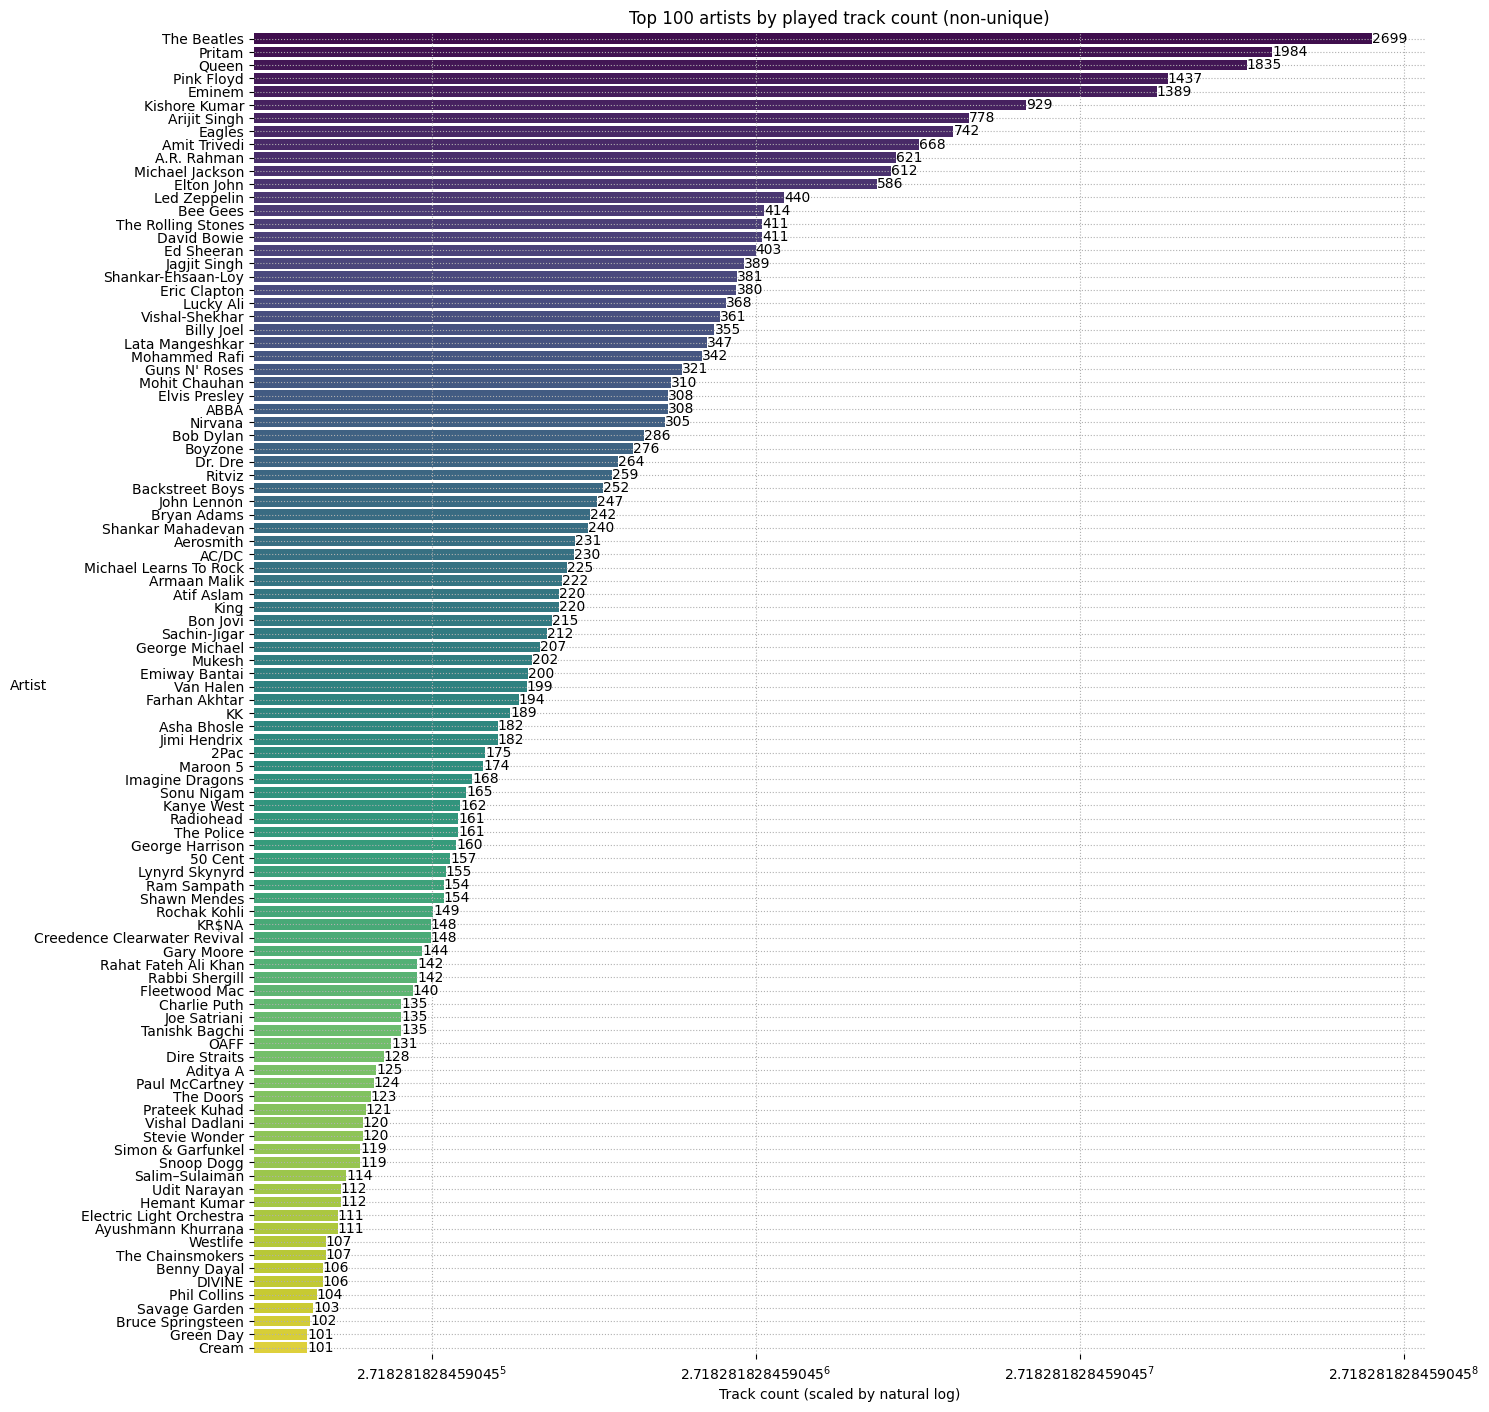

In [434]:
# Top artists by played track count
played_track_count = grouped_by_artist_name["master_metadata_album_artist_name"].count()
played_track_count.sort_values(ascending=False, inplace=True)
Plots.plot_1(played_track_count, 100, "Top 100 artists by played track count (non-unique)", "Track count (scaled by natural log)", "Artist")

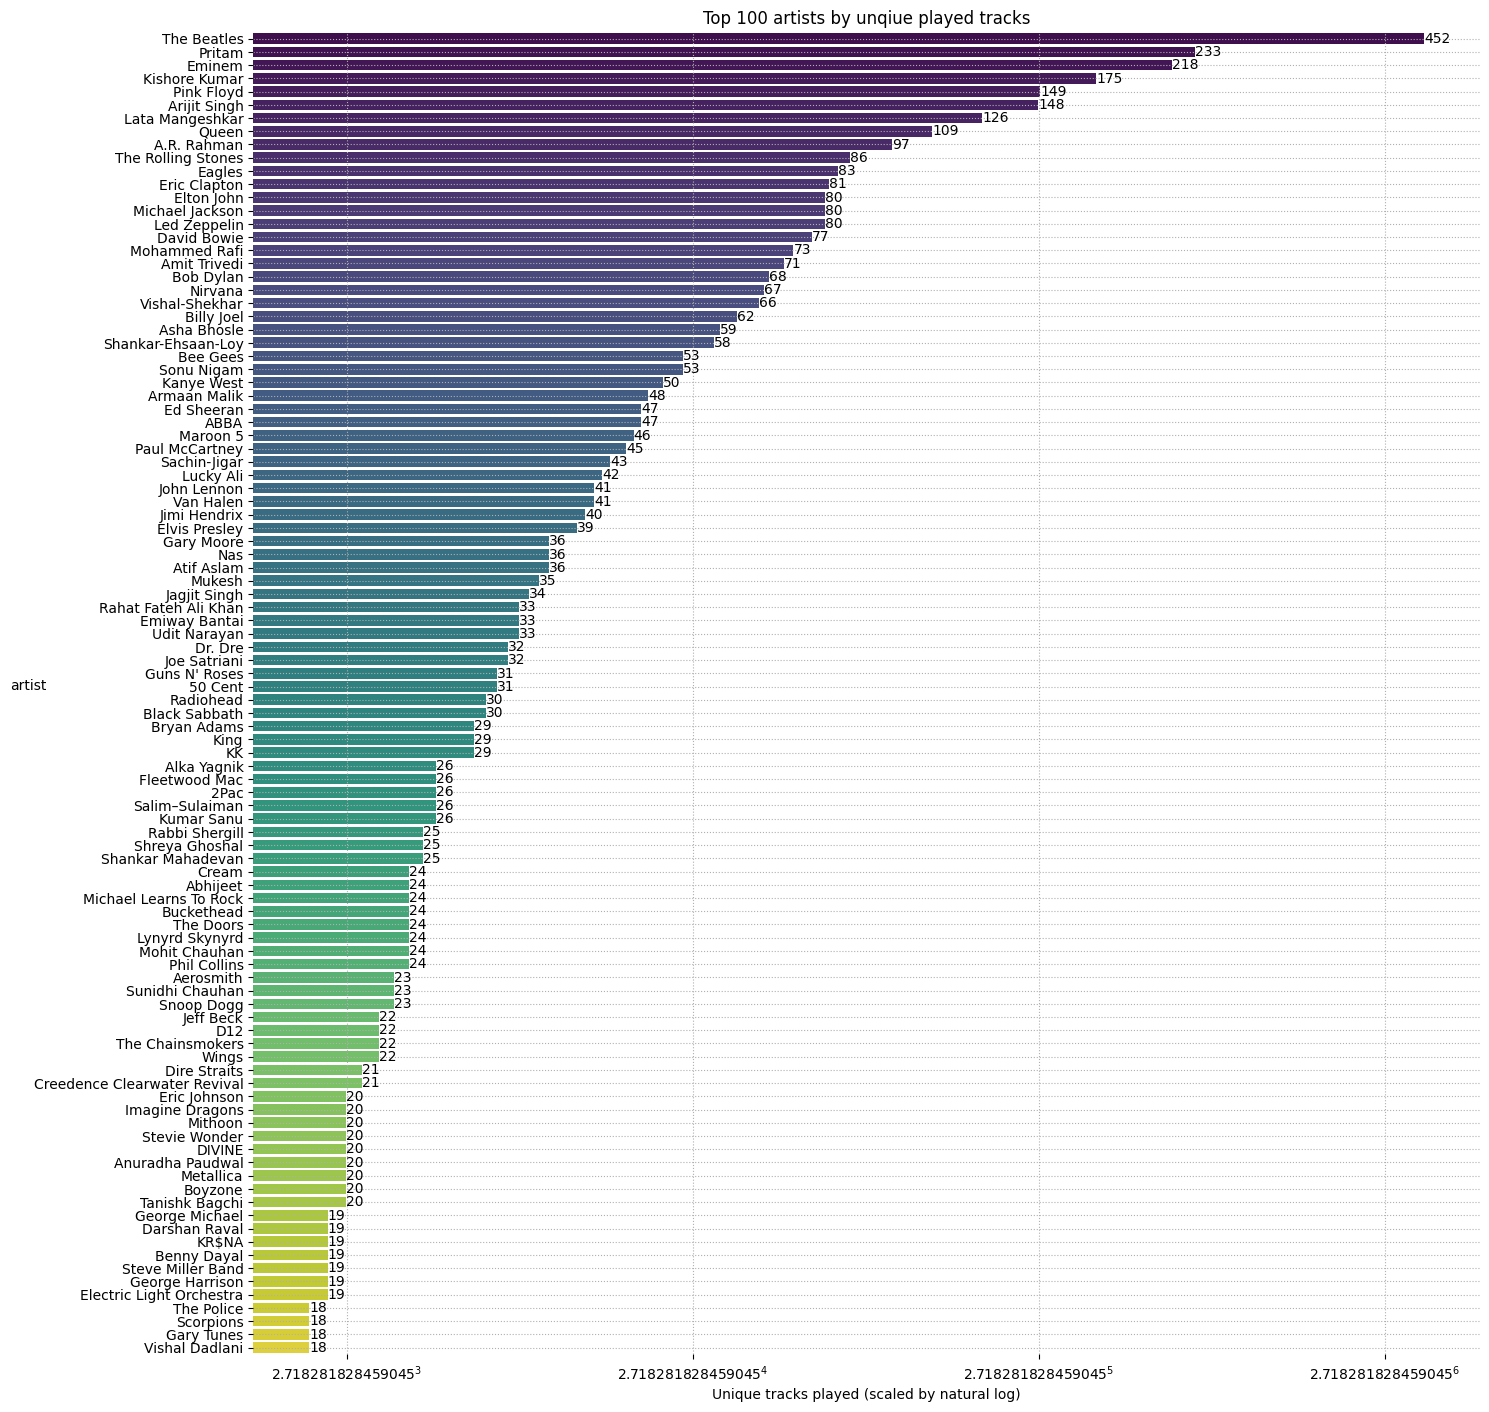

In [435]:
# select artist, distinct track_name, count(track_name) from table

unique_tracks = grouped_by_artist_name["master_metadata_track_name"].nunique()
unique_tracks.sort_values(ascending=False, inplace=True)
Plots.plot_1(unique_tracks, 100, "Top 100 artists by unqiue played tracks", "Unique tracks played (scaled by natural log)", "artist")

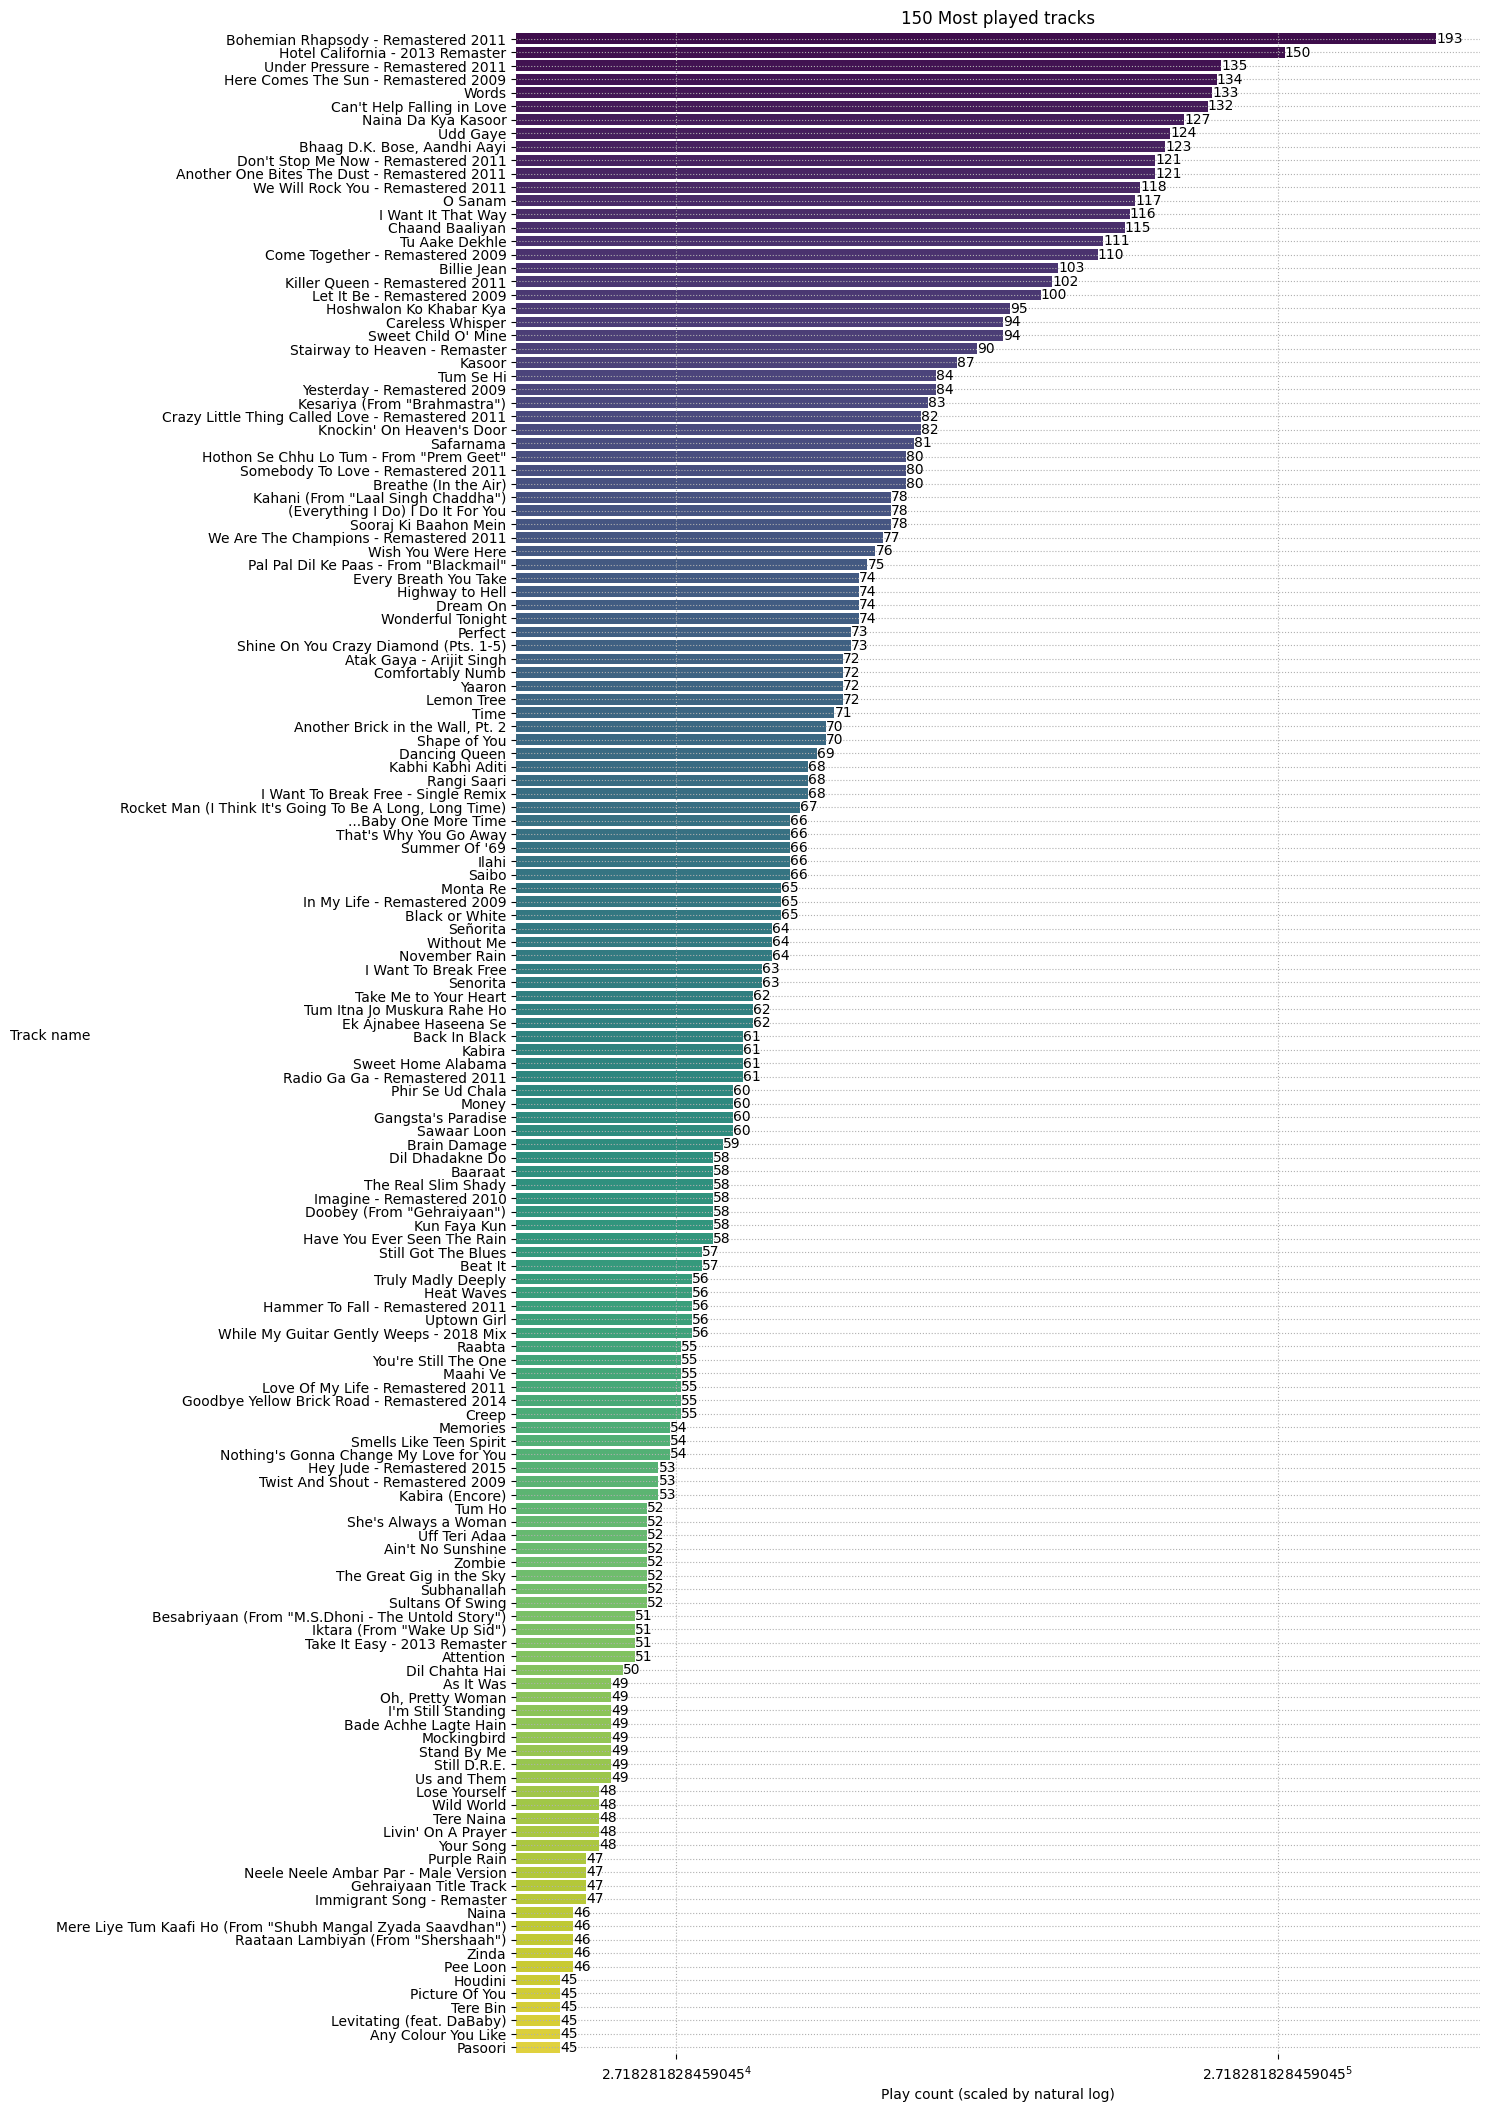

In [436]:
# Most played tracks
most_played_tracks = df.groupby(df["master_metadata_track_name"])["master_metadata_track_name"].count()
most_played_tracks.sort_values(ascending=False, inplace=True)
Plots.plot_1(most_played_tracks, 150, "150 Most played tracks", "Play count (scaled by natural log)", "Track name")


In [437]:
timestamp_regex= r"^(\d{4})-(\d{2})-(\d{2})T(\d{2}):(\d{2}):(\d{2})Z$"
pattern = re.compile(timestamp_regex)

# 2020-11-27T07:19:29Z

def extract_from_timestamp(what:Literal["year", "month", "day", "date", "hour", "minute", "seconds", "time-24"], timestamp: str):
    m = re.match(pattern, timestamp)
    if(m is None):
        raise ValueError("Cannot find match in timestamp " + timestamp)
    match(what):
        case "year":
            return m.group(1)
        case "month":
            return m.group(2)
        case "day":
            return m.group(3)
        case "date":
            return f"{m.group(1)}-{m.group(2)}-{m.group(3)}"
        case "hour":
            return m.group(4)

        case "minute":
            return m.group(5)
        case "seconds":
            return m.group(6)
        case "time-24":
            return f"{m.group(4)}:{m.group(5)}:{m.group(6)}"

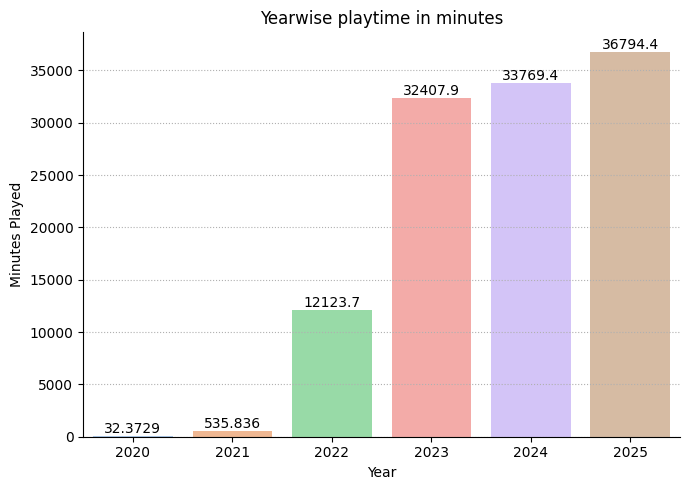

In [438]:
# yearwise listening minutes
with_dates = df.copy(True)
with_dates["ts"] = with_dates["ts"].apply(lambda ts: extract_from_timestamp("year", ts))
grouped_by_ts = with_dates.groupby("ts")
total_playtime = grouped_by_ts["ms_played"].sum()
total_playtime = total_playtime.div(6e4)
Plots.plot_2(total_playtime, "Yearwise playtime in minutes", "Year", "Minutes Played")

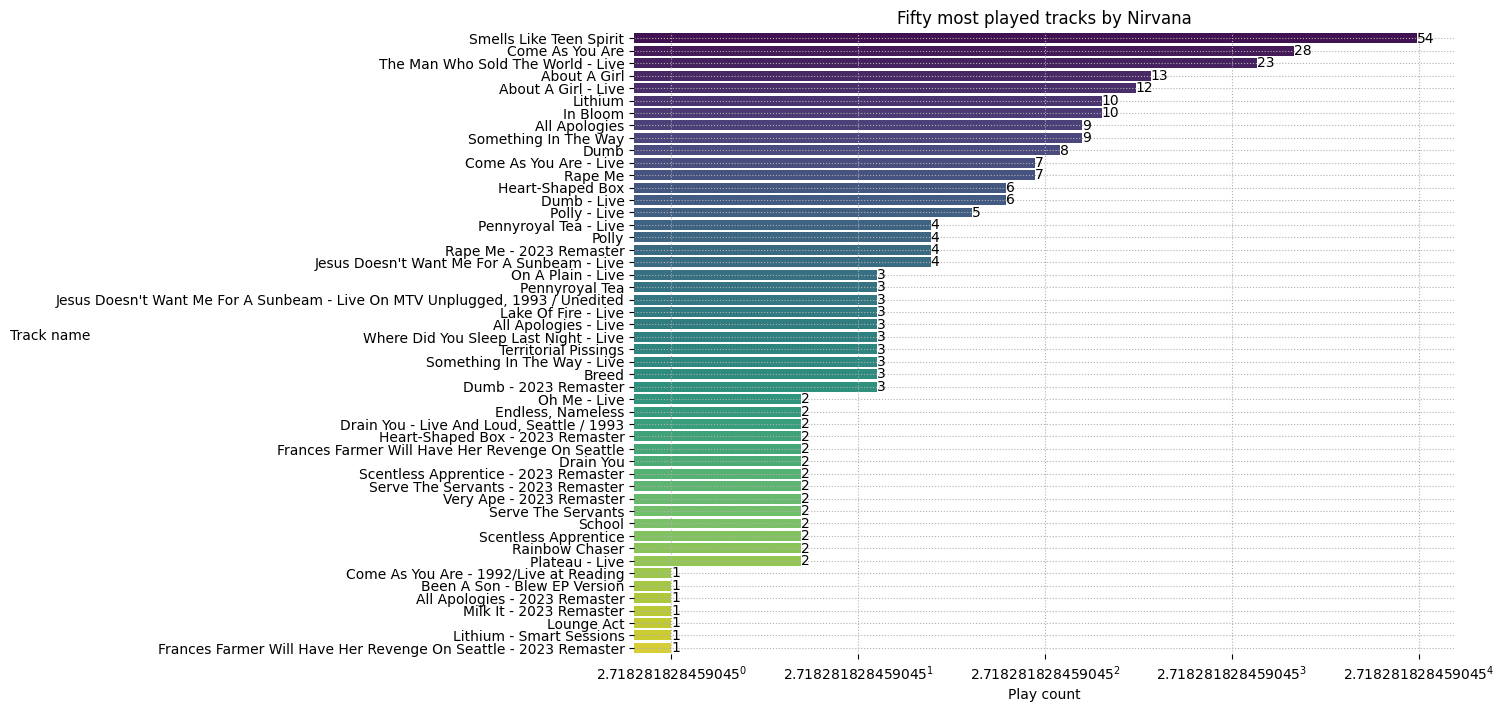

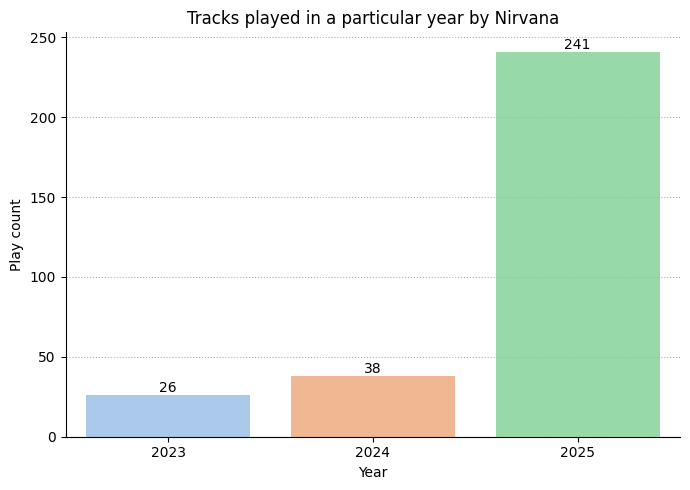

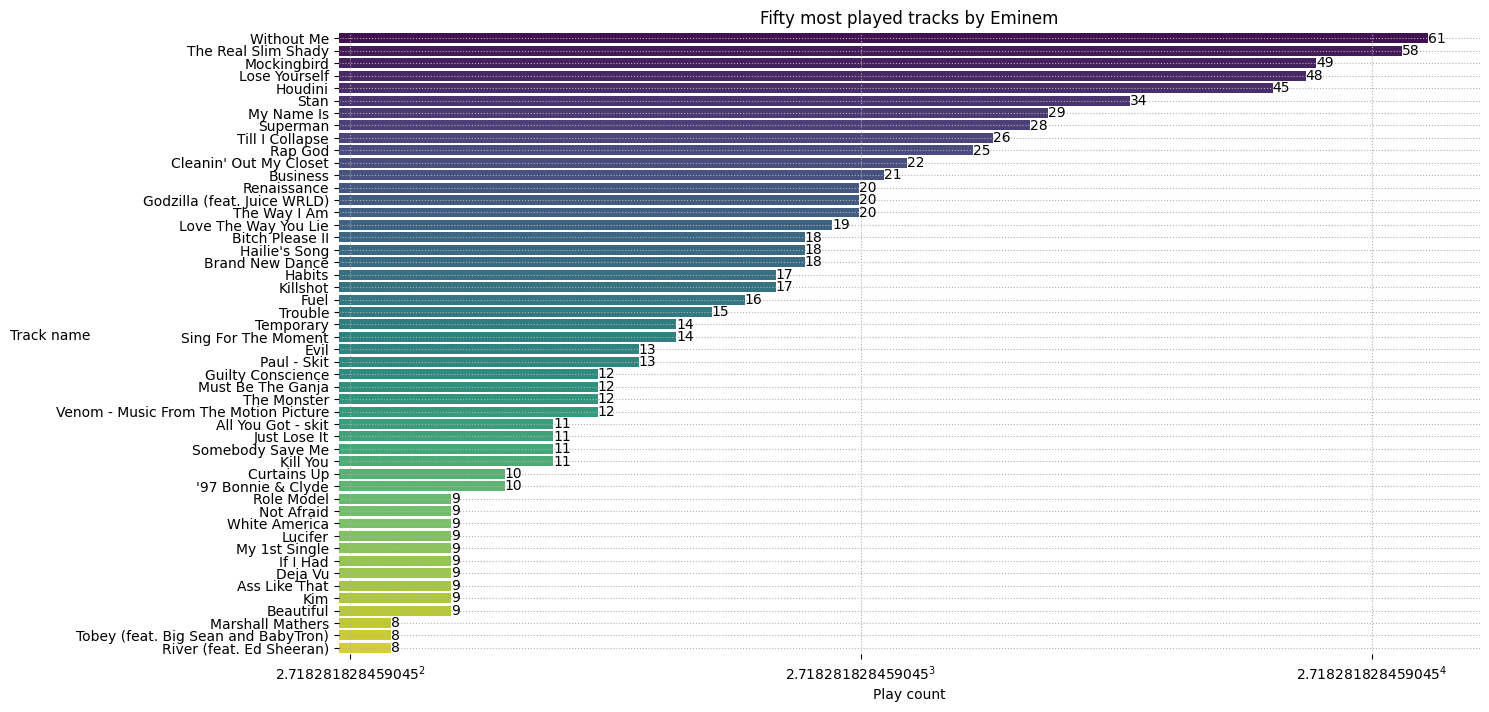

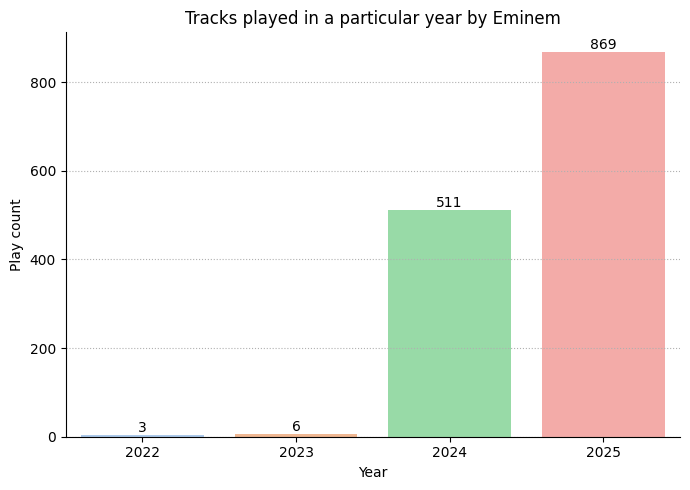

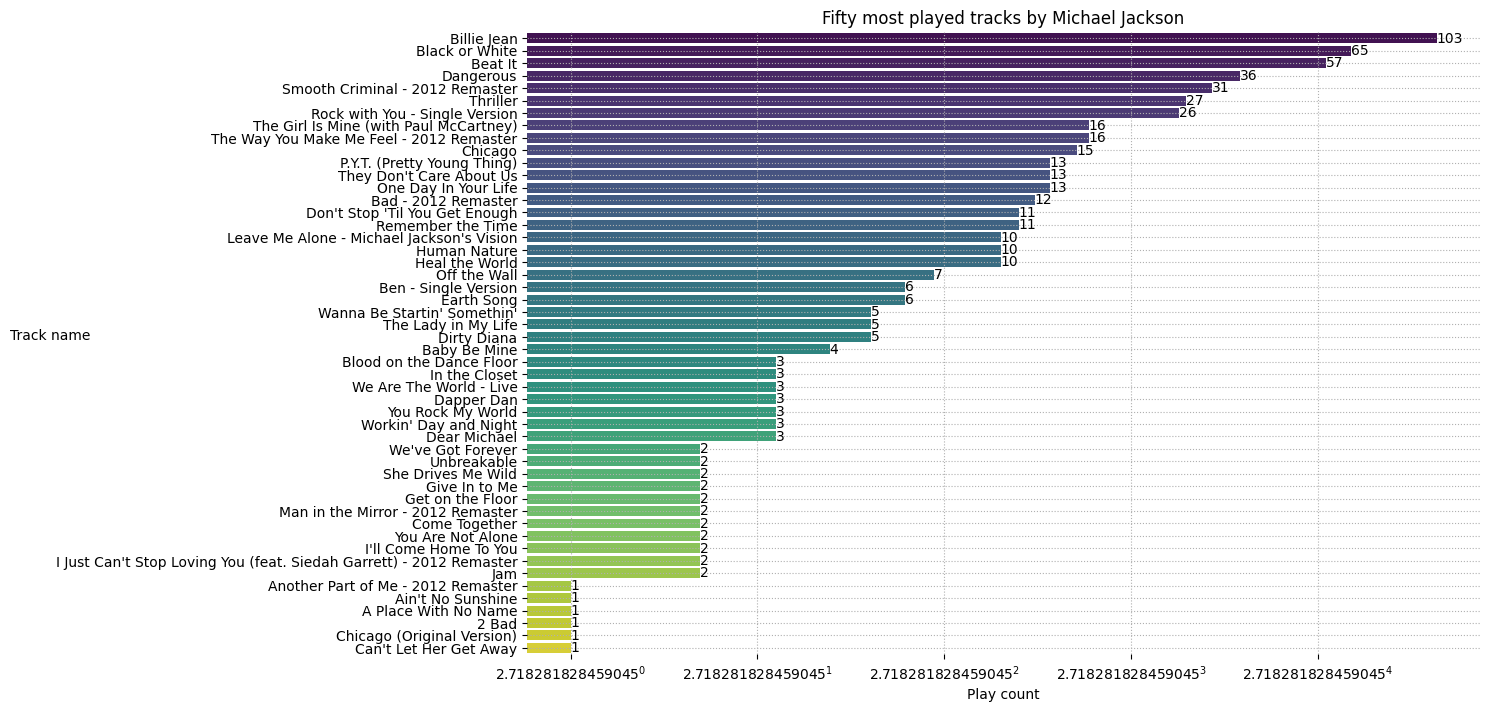

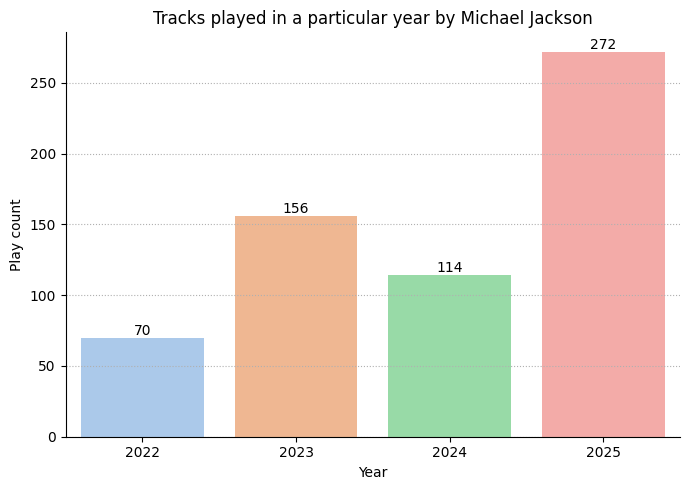

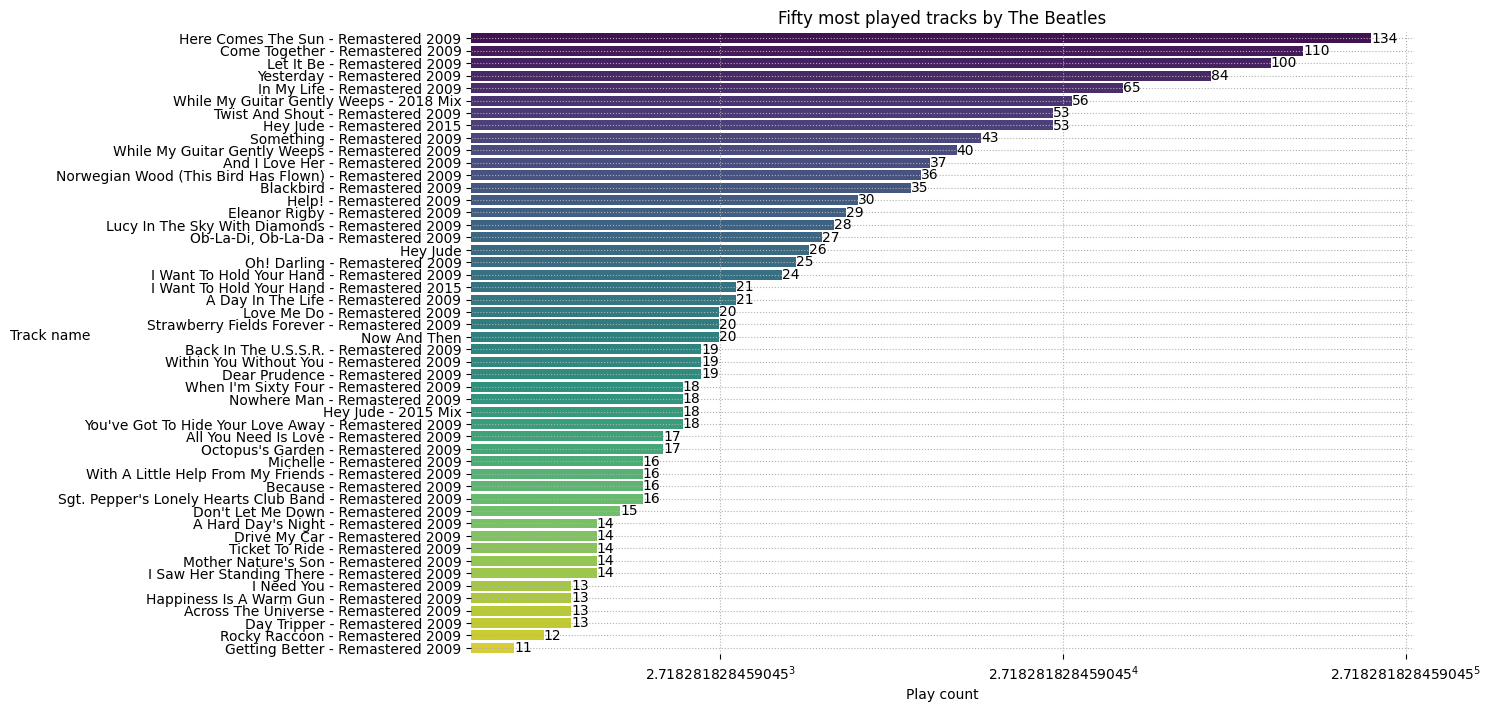

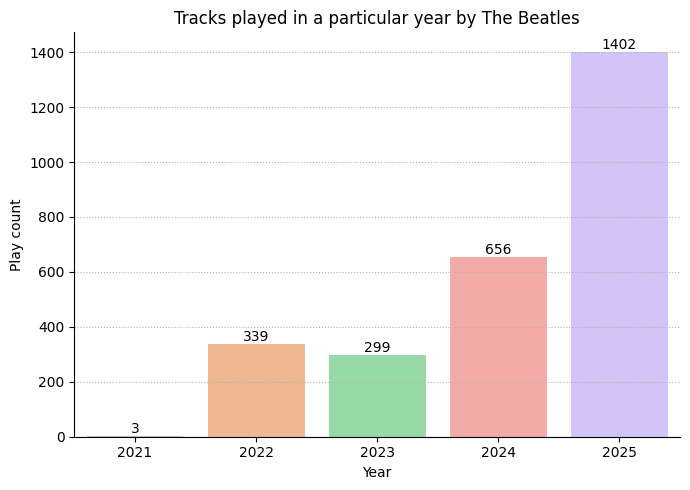

In [439]:
def analysis_per_artist(frame: pd.DataFrame, artist:str):
    if(artist not in frame["master_metadata_album_artist_name"].values):
        raise ValueError(f"Artist {artist} is not in data")

    artist_frame = frame[frame["master_metadata_album_artist_name"] == artist].copy(True)

    # grouped = artist_frame.groupby("master_metadata_album_artist_name")
    # changing ts to year
    artist_frame["year"] = artist_frame["ts"].apply(lambda ts: extract_from_timestamp("year", ts))

    # Top 50 played tracks
    played_track_count = (artist_frame
                          .groupby("master_metadata_track_name")
                          .size()
                          .sort_values(ascending=False))
    Plots.plot_1(played_track_count, 50, f"Fifty most played tracks by {artist}", "Play count", "Track name")
    
    # Year wise play time
    yearwise_playtime = (artist_frame
                         .groupby("year")
                         .size())
    Plots.plot_2(yearwise_playtime, f"Tracks played in a particular year by {artist}", "Year", "Play count")
    
    
    
analysis_per_artist(df, "Nirvana")
analysis_per_artist(df, "Eminem")
analysis_per_artist(df, "Michael Jackson")
analysis_per_artist(df, "The Beatles")